Source: https://www.kaggle.com/code/liamhealy/interest-rate-modelling-in-python/notebook

Introduction
This notebook is part of a series of notebooks which explore Data Science topics in Python:

Bayesian Hyperparameter Tuning in Python
Copulas in Python
Shapley Values in Python
Principle Component Analysis in Python
Interest Rate Modelling in Python
The purpose of this notebook to to develope an yield curve forecasting model that can be leveraged to predict the rance of interest rate yield curve outlooks across the next 12-months (or more). The methodology outlines in this notebook will leverage dimension reduction techniques and stocastic modelling.

Utilizing Principal Component Analysis (PCA) and the Vasicek simulation model proves invaluable in simulating and understanding the complex dynamics of US yield curves. PCA identifies key factors influencing interest rate variations, enabling a more concise representation of yield curve movements. The Vasicek model, incorporating mean reversion, then facilitates the stochastic simulation of future interest rate paths. By integrating PCA-derived principal components into the Vasicek framework, analysts can enhance the granularity of simulations, capturing both systematic factors and the inherent uncertainty in interest rate changes. This combined approach finds applications in risk management, scenario analysis, and portfolio optimization, empowering financial analysts to make more informed decisions by comprehensively simulating the intricate behavior of US yield curves.

In [ ]:
# %pip install seaborn
# %pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------- ----------------------- 4.2/9.9 MB 22.9 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.9 MB 23.1 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 18.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Evironment setup

In [1]:
# Import the required packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from scipy.optimize import minimize

### Define the colour scheme
c1 = "#173f5f"
c2 = "#20639b"
c3 = "#3caea3"
c4 = "#f6d55c"
c5 = "#ed553b"

custom_palette = [c1, c2, c3, c4, c5]
sns.palplot(sns.color_palette(custom_palette))

# User defined function
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#total'] = df.shape[0]
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

ModuleNotFoundError: No module named 'sklearn'

Data Processing

In [ ]:
# Import the data
df = pd.read_csv('./yield-curve-rates-1990-2024.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)

# Sort by Date
df = df.sort_values('Date')

# Date as index
df.set_index('Date', inplace=True)

# List the variables to keep (<25% missing) and rename
keep_vars = ['3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','20 Yr']
rename_vars = ['3m','6m','12m','24m','36m','60m','84m','120m','240m']

# drop variable and rename
df = df[keep_vars]
df.columns = rename_vars

# Interpolate missing values linearly
df = df.interpolate()

# Drop rows with missing values still (when missing at beginning or end of time series)
df = df.dropna()

# View the data
summary(df).style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max
3m,float64,7818,0,0.000000,631,7187,0.000000,6.420000
6m,float64,7818,0,0.000000,638,7180,0.020000,6.670000
12m,float64,7818,0,0.000000,686,7132,0.040000,7.320000
24m,float64,7818,0,0.000000,729,7089,0.090000,7.740000
36m,float64,7818,0,0.000000,748,7070,0.100000,7.840000
60m,float64,7818,0,0.000000,742,7076,0.190000,7.900000
84m,float64,7818,0,0.000000,733,7085,0.360000,7.920000
120m,float64,7818,0,0.000000,726,7092,0.520000,8.050000
240m,float64,7818,0,0.000000,716,7102,0.870000,8.300000


Visualising Data

In [ ]:
def plot_rates(df):
    plot_vars = df.columns
    
    fig, ax = plt.subplots(figsize=(8,4), ncols=1, nrows=1)
    for var in plot_vars:
        ax.plot(df.index, df[var], label=var, lw=0.5)
    ax.set(title='Daily Interest Rate', xlabel='Date', ylabel='Interest Rate (%)')
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

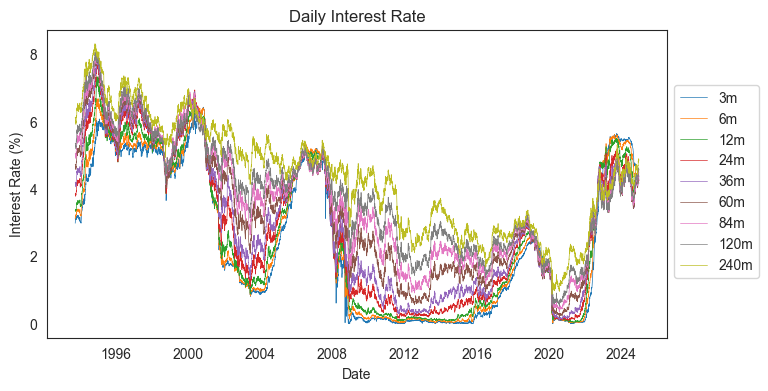

In [ ]:
# Plot the daily interest rates
plot_rates(df)